In [1]:
%matplotlib inline

In [2]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import xyzpy as xyz
import json

In [28]:
!exa -lah *.json

Permissions Size User    Date Modified Name
.rw-r--r--  5.9k johnnie 11 Oct 15:07  oe_sample_MAXCUT_n30_reg3_seed0.json
.rw-r--r--  5.9k johnnie 11 Oct 15:07  oe_sample_MAXCUT_n30_reg3_seed1.json
.rw-r--r--  5.9k johnnie 11 Oct 15:07  oe_sample_MAXCUT_n30_reg3_seed2.json
.rw-r--r--  7.4k johnnie 11 Oct 15:08  oe_sample_MAXCUT_n30_reg4_seed0.json
.rw-r--r--  7.4k johnnie 11 Oct 15:08  oe_sample_MAXCUT_n30_reg4_seed1.json
.rw-r--r--  7.4k johnnie 11 Oct 15:08  oe_sample_MAXCUT_n30_reg4_seed2.json
.rw-r--r--  8.9k johnnie 11 Oct 15:08  oe_sample_MAXCUT_n30_reg5_seed0.json
.rw-r--r--  8.9k johnnie 11 Oct 15:08  oe_sample_MAXCUT_n30_reg5_seed1.json
.rw-r--r--  8.9k johnnie 11 Oct 15:08  oe_sample_MAXCUT_n30_reg5_seed2.json
.rw-r--r--   10k johnnie 11 Oct 14:59  oe_sample_MAXCUT_n50_reg3_seed0.json
.rw-r--r--   10k johnnie 11 Oct 14:59  oe_sample_MAXCUT_n50_reg3_seed1.json
.rw-r--r--   10k johnnie 11 Oct 14:59  oe_sample_MAXCUT_n50_reg3_seed2.json
.rw-r--r--   12k johnnie 11 Oct 14:59  oe_sa

In [3]:
def TN_to_eq_shapes(tn):
    """Convert a quimb TN into opt_einsum eq and shapes.
    """
    ts = tn.tensors
    expr = qtn.tensor_contract(*ts, get='expression', optimize='eager')
    eq = expr.contraction
    shapes = [t.shape for t in ts]
    return eq, shapes

def eq_shapes_to_json(eq, shapes, fname):
    """Write eq and shapes to JSON.
    """
    with open(fname, 'w') as file:
        json.dump({'eq': eq, 'shapes': shapes}, file)
        
def eq_shapes_from_json(fname):
    """Load eq and shapes from JSON
    """
    with open(fname) as file:
        loaded = json.load(file)
        eq, shapes = loaded['eq'], loaded['shapes']
    return eq, shapes

# QAOA Maxcut

In [4]:
def rand_reg_graph(reg, n, seed=None):
    import networkx as nx
    G = nx.random_regular_graph(reg, n, seed=seed)
    return G

def graph_to_circ(G, gamma0=-0.743043, beta0 = 0.754082):
    n = G.number_of_nodes()
    
    # add all the gates
    circ = "{}\n".format(n)
    for i in range(n):
        circ += "H {}\n".format(i)
    for i, j in G.edges:
        circ += "CNOT {} {}\n".format(i, j)
        circ += "Rz {} {}\n".format(gamma0, j)
        circ += "CNOT {} {}\n".format(i, j)
    for i in range(n):
        circ += "Rx {} {}\n".format(beta0, i)
        
    return circ

def do_circuit(info):
    qc = qtn.Circuit(info['n'])
    qc.apply_circuit(info['gates'])
    return qc.psi

def psi_gamma_beta_G(n, reg, seed, gamma0, beta0):
    G = rand_reg_graph(reg, n, seed=seed)
    circ = graph_to_circ(G, gamma0=gamma0, beta0=beta0)
    info = qtn.circuit.parse_qasm(circ)
    return do_circuit(info).squeeze(), G

Generate the circuit:

In [52]:
n = 40
reg = 5
seed = 2

psi_f, G = psi_gamma_beta_G(n, reg, seed, gamma0=0.874729, beta0=0.8471024)
s = qtn.MPS_sampler(psi_f.nsites)
norm = s & psi_f

In [53]:
fname = "oe_sample_MAXCUT_n{}_reg{}_seed{}.json".format(n, reg, seed)
print(fname)

eq_shapes_to_json(*TN_to_eq_shapes(norm), fname)

oe_sample_MAXCUT_n40_reg5_seed2.json


In [54]:
!ls -l *.json

-rw-r--r-- 1 johnnie johnnie  5938 Oct 11 15:07 oe_sample_MAXCUT_n30_reg3_seed0.json
-rw-r--r-- 1 johnnie johnnie  5938 Oct 11 15:07 oe_sample_MAXCUT_n30_reg3_seed1.json
-rw-r--r-- 1 johnnie johnnie  5938 Oct 11 15:07 oe_sample_MAXCUT_n30_reg3_seed2.json
-rw-r--r-- 1 johnnie johnnie  7423 Oct 11 15:08 oe_sample_MAXCUT_n30_reg4_seed0.json
-rw-r--r-- 1 johnnie johnnie  7423 Oct 11 15:08 oe_sample_MAXCUT_n30_reg4_seed1.json
-rw-r--r-- 1 johnnie johnnie  7423 Oct 11 15:08 oe_sample_MAXCUT_n30_reg4_seed2.json
-rw-r--r-- 1 johnnie johnnie  8908 Oct 11 15:08 oe_sample_MAXCUT_n30_reg5_seed0.json
-rw-r--r-- 1 johnnie johnnie  8908 Oct 11 15:08 oe_sample_MAXCUT_n30_reg5_seed1.json
-rw-r--r-- 1 johnnie johnnie  8908 Oct 11 15:08 oe_sample_MAXCUT_n30_reg5_seed2.json
-rw-r--r-- 1 johnnie johnnie  8083 Oct 11 15:09 oe_sample_MAXCUT_n40_reg3_seed0.json
-rw-r--r-- 1 johnnie johnnie  8083 Oct 11 15:09 oe_sample_MAXCUT_n40_reg3_seed1.json
-rw-r--r-- 1 johnnie johnnie  8083 Oct 11 15:09 oe_sample_MAXCUT_

### analysis

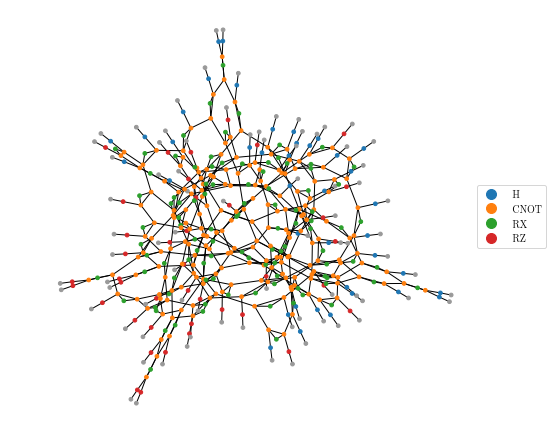

In [55]:
norm.graph(color=['H', 'CNOT', 'RX', 'RZ'])

In [56]:
# the greedy contraction complexity
ccg = norm.contraction_complexity(optimize='greedy')
ccg

27.0

In [57]:
# 100 random eager contraction complexities
ccs = np.array([norm.contraction_complexity(optimize='eager') for _ in xyz.progbar(range(100))])

100%|##########| 100/100 [00:13<00:00,  7.34it/s]


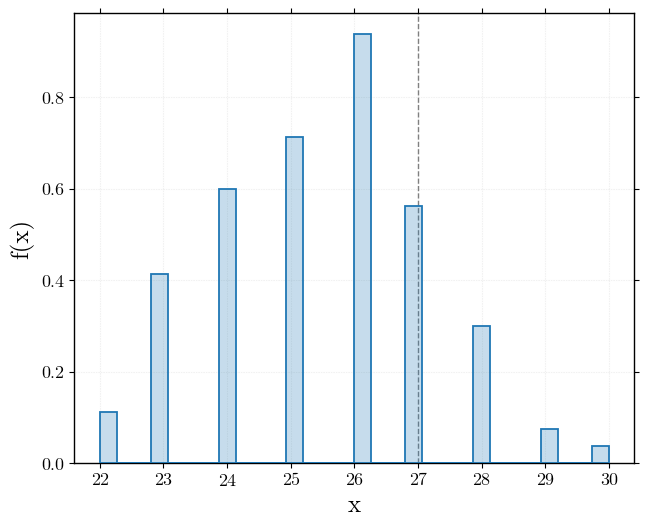

In [60]:
xyz.auto_histogram(ccs, vlines=[ccg])